# Feladatleírás

## Választott feladat

Felügyeletlen előtanítás CNN Autoencoder használatával, majd fine-tuning felügyelt klasszifikációs feladatra.

## Kísérletek

* Néhány vizualizáció az autoencoder által generált heatmapekről, és az általa rekonstruált képekről
* Az fine-tuned modell teljesítményének összevetése egy olyan változattal, ahol csak felügyelt módon tanult klasszifikálni a háló (3 változatban, a címkézett képek számának változtatásával)

## Adathalmaz
https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class/data

## Mit várhatunk a fine-tuned modelltől?

Mivel a célfeladaton meglehetősen kevés képünk áll rendelkezésre, ezért azt lehet feltételezni, hogy a felügyeletlen módon tanult autoencoder súlyait felhasználó klasszifikáló háló valamelyest jobb eredményeket ér el, mint a sima klasszifikáló háló, abban az esetben, ha az encoder háló tanult hasznos súlyokat.

Ennek tesztelésére a fine-tuned modell eredményeit összevetem egy, az encoder rétegeihez hasonló CNN klasszifikációs hálóval, három féle konfigurációban:

1. Autoencoder 50%-on tanul, fine-tuned 10%-on, teszt 10%-on (és validáció 10%-on)
2. Autoencoder 50%-on tanul, fine-tuned 20%-on, teszt 10%-on (és validáció 10%-on)
3. Autoencoder 50%-on tanul, fine-tuned 30%-on, teszt 10%-on (és validáció 10%-on)

# Előkészületek

## Adatbázis letöltése

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download karimabdulnabi/fruit-classification10-class
!unzip fruit-classification10-class.zip
!rm fruit-classification10-class.zip
!mv MY_data fruits-dataset

# resolving directory name inconsistencies
!mv fruits-dataset/test/stawberries fruits-dataset/test/strawberries
!mv fruits-dataset/train/Apple fruits-dataset/train/apple
!mv fruits-dataset/train/Banana fruits-dataset/train/banana
!mv fruits-dataset/train/pinenapple fruits-dataset/train/pineapple
!mv fruits-dataset/test/pinenapple fruits-dataset/test/pineapple

## Importok

In [ ]:
from PIL import Image
import os

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn import metrics
import seaborn
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense,\
  UpSampling2D, Reshape, Dropout, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Adatbázis betöltése

In [ ]:
RESOLUTION = (64, 64)
categories = ["apple", "avocado", "banana", "cherry", "kiwi", "mango", "orange", "pineapple", "strawberries", "watermelon"]


def load_image(img_path):
  img = Image.open(img_path)
  img_rescaled = img.resize(RESOLUTION)
  img_arr = np.array(img_rescaled)

  # normalizing values to [0,1]
  img_arr = img_arr / 255.0

  return img_arr

def load_files(dictionary, path):
  for subdir in os.listdir(path):
    fruit = subdir
    joined_path = os.path.join(path, subdir)

    if fruit not in dictionary.keys():
      dictionary[fruit] = []

    for file in os.listdir(joined_path):
      path_with_file = os.path.join(joined_path, file)
      dictionary[fruit].append(load_image(path_with_file))

dataset = {}
load_files(dataset, './fruits-dataset/train')
load_files(dataset, './fruits-dataset/test')

### Helyes betöltés tesztelése

*   Az egyes kategóriákhoz tartozó képek számának megvizsgálása
*   Mind a tíz kategóriából megjelenítésre kerül 1-1 véletlenszerű kép


          Fruit  Files count
0         apple          319
1       avocado          335
2        banana          336
3        cherry          335
4          kiwi          335
5         mango          336
6        orange          327
7     pineapple          335
8  strawberries          333
9    watermelon          335

Total number of images: 3326


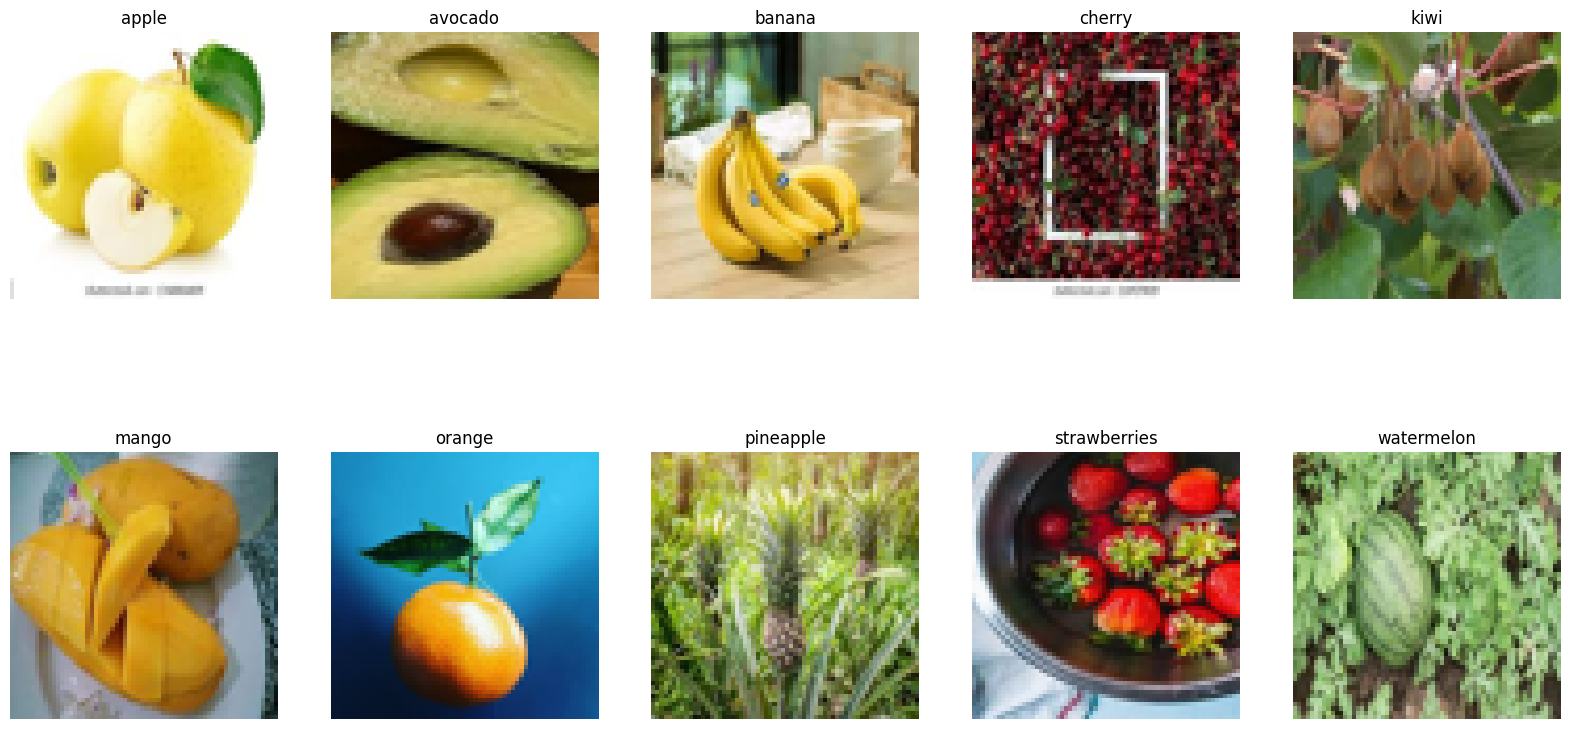

In [ ]:
df = pd.DataFrame(list(dataset.items()), columns=['Fruit', 'Images'])
df['Files count'] = df['Images'].apply(len)
df.drop(columns=['Images'], inplace=True)
df.sort_values('Fruit', inplace=True)
df.reset_index(drop = True, inplace = True)

total_num_of_imgs = df['Files count'].sum()

print(df)
print("\nTotal number of images:", total_num_of_imgs)

fig, axs = plt.subplots(2, 5)
fig.set_figheight(10)
fig.set_figwidth(20)
for plot_idx in range(10):
    fruit = categories[plot_idx]
    img_arr = dataset[fruit]
    selected_img_idx = np.random.choice(len(img_arr))

    axs[plot_idx // 5, plot_idx % 5].imshow(img_arr[selected_img_idx])
    axs[plot_idx // 5, plot_idx % 5].axis('off')
    axs[plot_idx // 5, plot_idx % 5].set_title(fruit)

## Függvény definiálása az adatbázis felosztásához

In [ ]:
 # returns the onehot vector for a category
def get_onehot(category):
  label = categories.index(category)
  return np.eye(len(categories))[label]


def permutate(xs, ys):
  if len(xs) == 0 or len(ys) ==  0:
    return (xs, ys)

  xs = np.stack(xs, axis=0)
  ys = np.stack(ys, axis=0)

  # changing order of images and labels

  permutation = np.random.permutation(len(xs))

  xs = xs[permutation]
  ys = ys[permutation]

  return (xs, ys)

def normalize_pixels(image):
  # normalizing to [0, 1]
  image = image / 255.0

# e.g. for a 50%-10%-20%-20% split the split parameter should be: (50, 10, 20, 20)
def split_dataset(dataset, split):
  (autoencoder_p, finetuned_p, test_p, validation_p) = split

  xs_autoencoder = []
  xs_finetuned, ys_finetuned = [], []
  xs_test, ys_test = [], []
  xs_val, ys_val = [], []

  for fruit in dataset.keys():
    num_of_imgs = len(dataset[fruit])

    first_bound = int(num_of_imgs * (autoencoder_p / 100.0))
    xs_autoencoder += dataset[fruit][:first_bound]

    second_bound = len(dataset[fruit][:first_bound]) + int(num_of_imgs * (finetuned_p / 100.0))
    xs_finetuned += dataset[fruit][first_bound:second_bound]
    ys_finetuned += [get_onehot(fruit) for _ in range(second_bound - first_bound)]

    third_bound = len(dataset[fruit][:second_bound]) + int(num_of_imgs * (test_p / 100.0))
    xs_test += dataset[fruit][second_bound:third_bound]
    ys_test += [get_onehot(fruit) for _ in range(third_bound - second_bound)]

    fourth_bound = len(dataset[fruit][:third_bound]) + int(num_of_imgs * (validation_p / 100.0))
    xs_val += dataset[fruit][third_bound:fourth_bound]
    ys_val += [get_onehot(fruit) for _ in range(fourth_bound - third_bound)]


  # Some images are in shape (x, x) instead of (x, x, 3)
  for (idx, img) in enumerate(xs_autoencoder):
    if img.shape == RESOLUTION:
      xs_autoencoder[idx] = np.stack((img,) * 3, axis=-1)
  for (idx, img) in enumerate(xs_finetuned):
    if img.shape == RESOLUTION:
      xs_finetuned[idx] = np.stack((img,) * 3, axis=-1)
  for (idx, img) in enumerate(xs_test):
    if img.shape == RESOLUTION:
      xs_test[idx] = np.stack((img,) * 3, axis=-1)
  for (idx, img) in enumerate(xs_val):
    if img.shape == RESOLUTION:
      xs_val[idx] = np.stack((img,) * 3, axis=-1)

  autoencoder_data = (xs_autoencoder, xs_autoencoder)
  finetuned_data = (xs_finetuned, ys_finetuned)
  test_data = (xs_test, ys_test)
  val_data = (xs_val, ys_val)

  return autoencoder_data, finetuned_data, test_data, val_data

## Osztályok definiálása az egyes modellekhez

### Általános modell

In [ ]:
class BaseModel():
  def __init__(self, xs=[], ys=[], xs_val=[], ys_val=[]):
    self.xs = xs
    self.ys = ys
    self.xs_val = xs_val
    self.ys_val = ys_val

  def compile(self, optimizer, loss, metrics=[]):
    self.metrics=metrics
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print('Compilation completed')

  def set_model(self, model):
    self.model = model

  def summary(self):
    self.model.summary()

  def train(self, epochs=100, min_delta=0, batch_size=32, earlystopping=True, earlystopping_patience=10):
    self.init_data_generator(batch_size=batch_size)

    if earlystopping:
      print('Early stopping on')

      early_stopping = EarlyStopping(
        monitor="val_loss",
        mode='min',
        patience=earlystopping_patience,
        min_delta=min_delta
      )

      self.history = self.model.fit(
        x=self.train_generator,
        epochs=epochs,
        validation_data=self.val_generator,
        callbacks=[early_stopping]
      )
    else:
      print('Early stopping off')

      self.history = self.model.fit(
        x=self.train_generator,
        epochs=epochs,
        validation_data=self.val_generator
      )

    print('Training completed')

  def init_data_generator(self, batch_size=32):
    self.datagen = ImageDataGenerator(
        rotation_range = 60,
        horizontal_flip = True,
        shear_range = 0.2,
        dtype=np.float32)

    self.train_generator = self.datagen.flow(self.xs, self.ys, batch_size=batch_size)
    self.val_generator = self.datagen.flow(self.xs_val, self.ys_val, batch_size=batch_size)

  def plot_curves(self):
    self.train_loss = self.history.history['loss']
    self.val_loss = self.history.history['val_loss']

    if ('accuracy' in self.metrics):
      self.train_acc = self.history.history['accuracy']
      self.val_acc = self.history.history['val_accuracy']

    fig, ax = plt.subplots(1, len(self.metrics) + 1, figsize=(12, 6))

    ax[0].plot(self.train_loss, 'b', label='Training loss')
    ax[0].plot(self.val_loss, 'r', label='Validation loss')
    ax[0].set_title('loss on training and validation data')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('loss')
    ax[0].legend()

    for (idx, metric) in enumerate(self.metrics):
      idx += 1

      train_history = self.history.history[metric]
      val_history = self.history.history['val_' + metric]
      ax[idx].plot(train_history, 'b', label=f'Training {metric}')
      ax[idx].plot(val_history, 'r', label=f'Validation {metric}')
      ax[idx].set_title(f'{metric} on training and validation data')
      ax[idx].set_xlabel('Epochs')
      ax[idx].set_ylabel(f'{metric}')
      ax[idx].legend()


### Autoencoder

In [ ]:
class Autoencoder(BaseModel):
  def __init__(self, xs, val):
    super().__init__(xs, xs, val, val)

    self.build_encoder()
    self.build_decoder()

    super().set_model(Model(inputs=[self.input], outputs=[self.decoded]))

    print('Model initialization completed')

  def build_encoder(self):
    self.input = Input((*RESOLUTION, 3))

    self.conv1 = Conv2D(16, kernel_size=3, padding="same")(self.input)
    x = BatchNormalization()(self.conv1)
    x = Activation("relu")(x)

    self.conv2 = Conv2D(16, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(self.conv2)
    self.skip1 = Activation("relu")(x)

    self.p1 = MaxPooling2D(pool_size=2)(self.skip1)

    self.conv3 = Conv2D(32, kernel_size=3, padding="same")(self.p1)
    x = BatchNormalization()(self.conv3)
    x = Activation("relu")(x)

    self.conv4 = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(self.conv4)
    self.skip2 = Activation("relu")(x)

    self.p2 = MaxPooling2D(pool_size=2)(self.skip2)

    self.conv5 = Conv2D(64, kernel_size=3, padding="same")(self.p2)
    x = BatchNormalization()(self.conv5)
    x = Activation("relu")(x)

    self.conv6 = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(self.conv6)
    self.encoded = Activation("relu")(x)

  def build_decoder(self):
    self.convt1 = Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding="same")(self.encoded)

    x = Concatenate()([self.convt1, self.skip2])

    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    self.convt2 = Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu", padding="same")(x)

    x = Concatenate()([self.convt2, self.skip1])

    x = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    self.decoded = Conv2D(3, kernel_size=3, activation="linear", padding="same")(x)


### Finetuned classifier

In [ ]:
class FinetunedClassifier(BaseModel):
  def __init__(self, xs, ys, xs_val, ys_val, autoencoder):
    super().__init__(xs, ys, xs_val, ys_val)

    x = Flatten()(autoencoder.encoded)
    x = Dropout(0.4)(x)
    x = Dense(100, activation="relu", kernel_regularizer='l2')(x)
    x = Dropout(0.2)(x)
    x = Dense(len(categories), activation='softmax')(x)

    super().set_model(Model(inputs=autoencoder.input, outputs=x))

    print('Model initialization completed')

### Simple classifier

In [ ]:
class SimpleClassifier(BaseModel):
  def __init__(self, xs, ys, xs_val, ys_val):
    super().__init__(xs, ys, xs_val, ys_val)

    self.input = Input((*RESOLUTION, 3))

    x = Conv2D(8, kernel_size=3, padding="same")(self.input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(8, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(16, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(16, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(100, activation="relu", kernel_regularizer='l2')(x)
    x = Dropout(0.2)(x)
    x = Dense(len(categories), activation='softmax')(x)

    super().set_model(Model(inputs=self.input, outputs=x))

    print('Model initialization completed')

# Első konfiguráció (50%-10%-10%-10%)



* Az autoencoder az adathalmaz 50%-án tanul
* Az előtanított modellt az adatahalmaz 10%-án fine-tuneoljuk, a sima klasszifikáló az adathalmaz ugyan ezen 10%-án tanul
* Mindegyik modellt az adathalmaz 10-10%-án validáljuk és teszteljük



## Az adathalmaz felosztása



In [ ]:
SPLIT = (50, 10, 10, 10)

(autoencoder_data, finetuned_data, test_data, val_data) = split_dataset(dataset, SPLIT)

autoencoder_data = permutate(*autoencoder_data)
finetuned_data = permutate(*finetuned_data)
test_data = permutate(*test_data)
val_data = permutate(*val_data)

(xs_autoencoder, ys_autoencoder) = autoencoder_data
(xs_finetuned, ys_finetuned) = finetuned_data
(xs_test, ys_test) = test_data
(xs_val, ys_val) = val_data

df = pd.DataFrame(
    columns=["", f"Autoencoder (~{SPLIT[0]}%)", f"Finetuned (~{SPLIT[1]}%)", f"Test (~{SPLIT[2]}%)",
             f"Val (~{SPLIT[3]}%)", "Total"]
    , data = [
        ['x size', len(xs_autoencoder), len(xs_finetuned), len(xs_test), len(xs_val),
            (len(xs_autoencoder) + len(xs_finetuned) + len(xs_test) + len(xs_val))
        ],
        ['y size', len(ys_autoencoder), len(ys_finetuned), len(ys_test), len(ys_val),
            (len(ys_autoencoder) + len(ys_finetuned) + len(ys_test) + len(ys_val))
        ]
    ]
)


print(df)

           Autoencoder (~50%)  Finetuned (~10%)  Test (~10%)  Val (~10%)  \
0  x size                1659               327          327         327   
1  y size                1659               327          327         327   

   Total  
0   2640  
1   2640  


## Autoencoder

In [ ]:
autoencoder = Autoencoder(xs=xs_autoencoder, val=xs_val)

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model initialization completed
Compilation completed


In [ ]:
autoencoder.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_139 (Conv2D)         (None, 64, 64, 16)           448       ['input_20[0][0]']            
                                                                                                  
 batch_normalization_119 (B  (None, 64, 64, 16)           64        ['conv2d_139[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_134 (Activation  (None, 64, 64, 16)           0         ['batch_normalization_1

In [ ]:
autoencoder.train(epochs=100, min_delta=0.005, batch_size=64, earlystopping_patience=10)

Early stopping on
Epoch 1/100
26/26 [==============================] - 11s 163ms/step - loss: 0.4245 - mae: 0.4363 - val_loss: 0.1661 - val_mae: 0.3347
Epoch 2/100
26/26 [==============================] - 3s 115ms/step - loss: 0.0673 - mae: 0.1995 - val_loss: 0.1140 - val_mae: 0.2814
Epoch 3/100
26/26 [==============================] - 6s 212ms/step - loss: 0.0615 - mae: 0.1931 - val_loss: 0.0916 - val_mae: 0.2559
Epoch 4/100
26/26 [==============================] - 3s 114ms/step - loss: 0.0606 - mae: 0.1925 - val_loss: 0.0770 - val_mae: 0.2367
Epoch 5/100
26/26 [==============================] - 4s 144ms/step - loss: 0.0574 - mae: 0.1854 - val_loss: 0.0814 - val_mae: 0.2443
Epoch 6/100
26/26 [==============================] - 5s 205ms/step - loss: 0.0547 - mae: 0.1799 - val_loss: 0.0782 - val_mae: 0.2399
Epoch 7/100
26/26 [==============================] - 3s 115ms/step - loss: 0.0542 - mae: 0.1800 - val_loss: 0.0685 - val_mae: 0.2236
Epoch 8/100
26/26 [==============================]

### Tanítási görbék

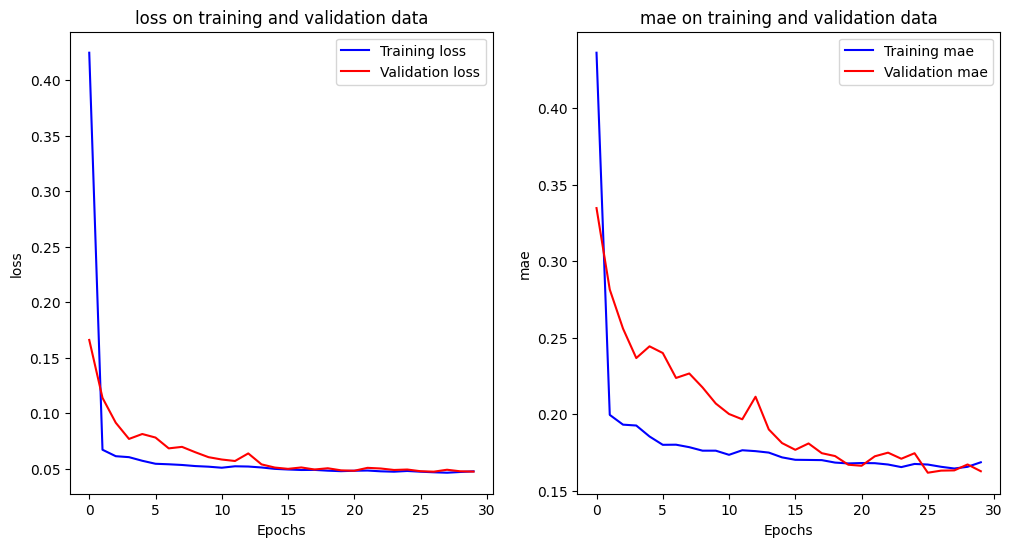

In [ ]:
autoencoder.plot_curves()

### Néhány rekonstrukció a teszthalmazon

1/1 [==============================] - 0s 20ms/step


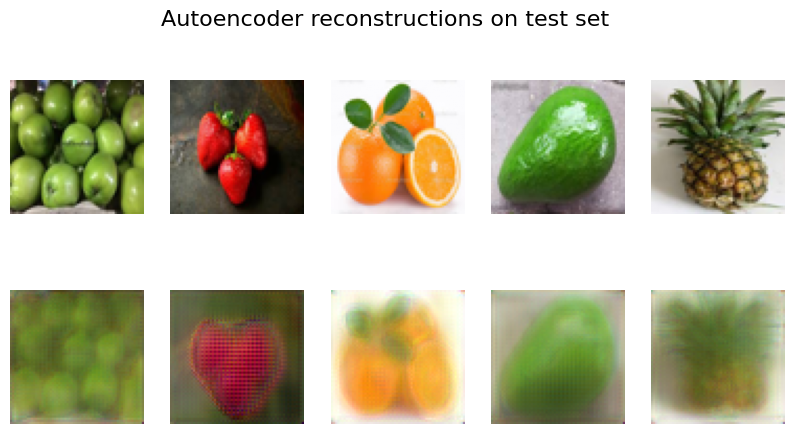

In [ ]:
def get_random_imgs(img_set, count):
  random_img_idxs = np.random.choice(len(img_set), count, replace=False)
  random_imgs = xs_test[random_img_idxs]

  return random_imgs


PREDICTION_COUNT = 5

random_imgs = get_random_imgs(xs_test, PREDICTION_COUNT)
predicted_imgs = autoencoder.model.predict(random_imgs)

fig, axs = plt.subplots(2, PREDICTION_COUNT)
fig.suptitle('Autoencoder reconstructions on test set', fontsize=16)
fig.set_figheight(5)
fig.set_figwidth(10)

for idx in range(PREDICTION_COUNT):
    axs[0, idx].axis('off')
    axs[1, idx].axis('off')
    axs[0, idx].imshow(random_imgs[idx])
    axs[1, idx].imshow(predicted_imgs[idx])

### Heatmapek vizualizációja az egyes rétegekben egy adott inputra

1/1 [==============================] - 0s 138ms/step


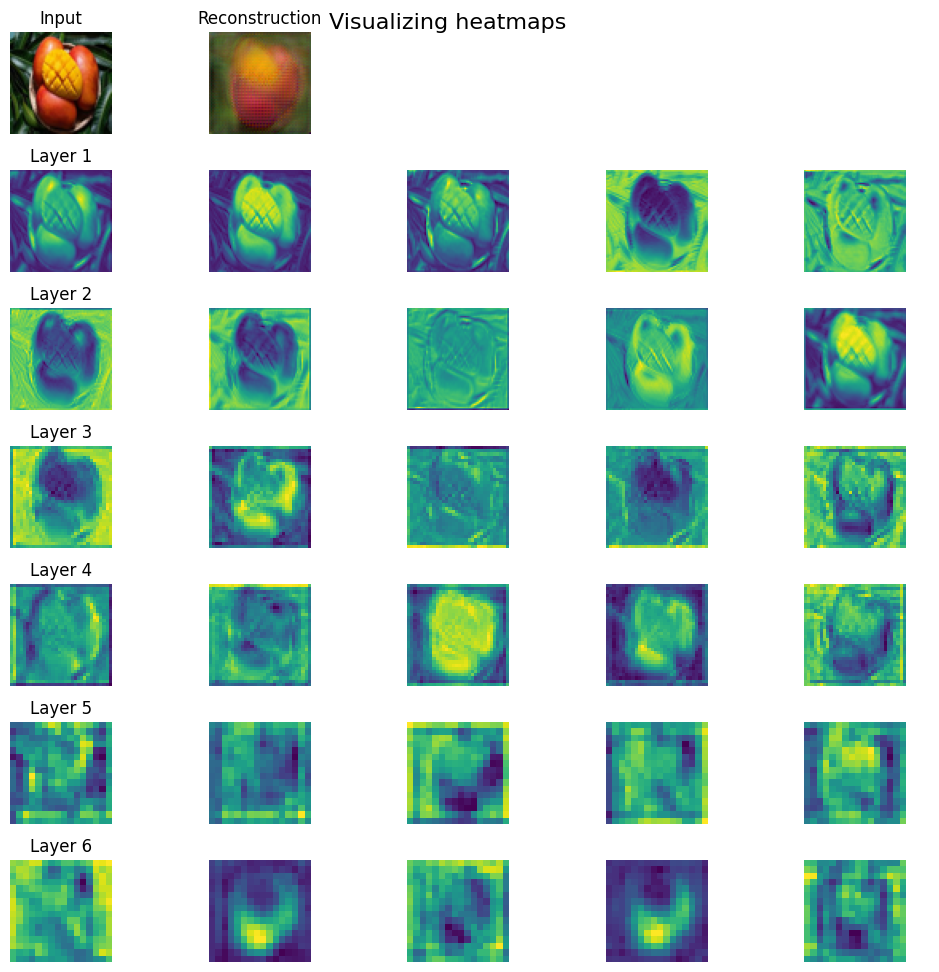

In [ ]:
model = Model(inputs=[autoencoder.input], outputs=[autoencoder.conv1, autoencoder.conv2,\
    autoencoder.conv3, autoencoder.conv4, autoencoder.conv5, autoencoder.conv6])

random_img_idx = np.random.choice(len(xs_test), 1, replace=False)
random_img = xs_test[random_img_idx]
predicted_img = autoencoder.model.predict(random_img)

FILTERS_PER_LAYER = 5

fig, axs = plt.subplots(len(model.outputs) + 1, FILTERS_PER_LAYER)
fig.suptitle('Visualizing heatmaps', fontsize=16)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=0.5)

for r in range(len(model.outputs) + 1):
  for c in range(FILTERS_PER_LAYER):
    axs[r, c].axis('off')

heatmaps = model.predict(random_img)

random_img = random_img.reshape(*RESOLUTION, 3)

axs[0,0].imshow(random_img)
axs[0,0].set_title('Input')
axs[0,1].imshow(predicted_img.reshape((*RESOLUTION, 3)))
axs[0,1].set_title('Reconstruction')

for (row_idx, heatmap) in enumerate(heatmaps):
  row_idx += 1
  axs[row_idx, 0].set_title(f'Layer {row_idx}')
  filter_idxs = np.random.choice(np.ma.size(heatmap, axis=3), FILTERS_PER_LAYER, replace=False)

  for col_idx in range(FILTERS_PER_LAYER):
    filter_idx = filter_idxs[col_idx]
    axs[row_idx , col_idx].imshow(heatmap[0,:,:,filter_idx])

### Megadott rétegben az összes heatmap vizualizációja

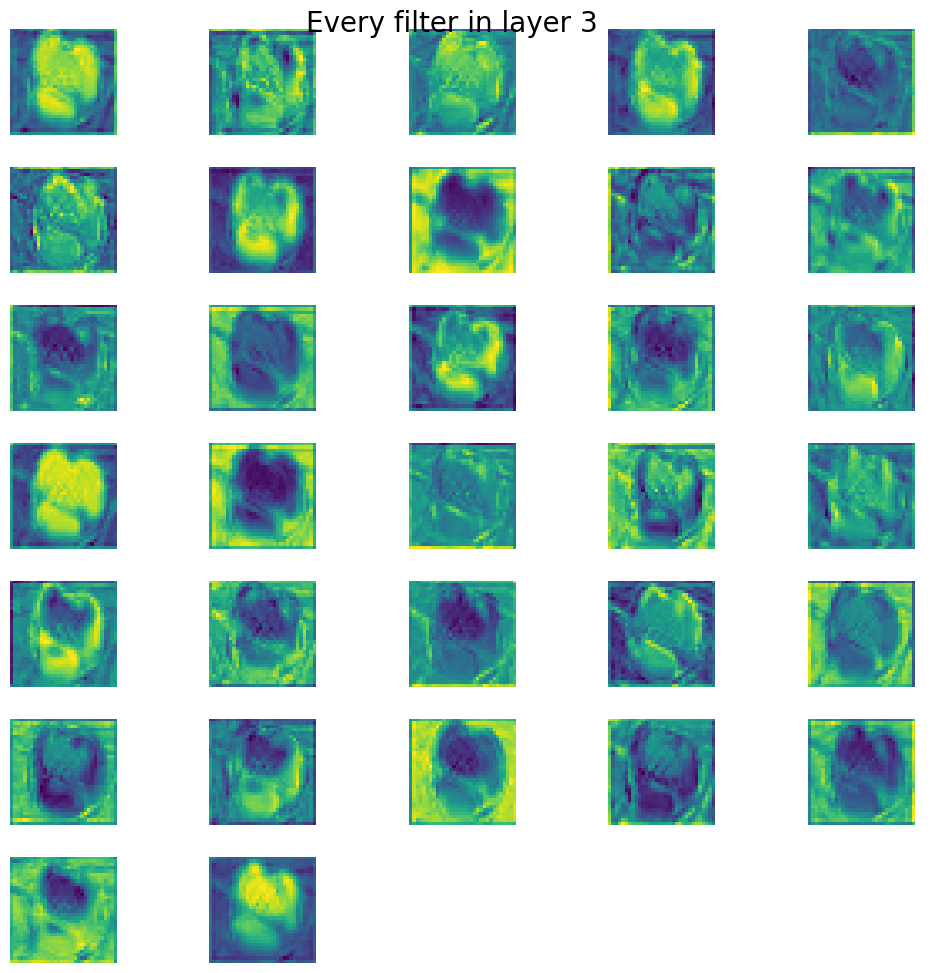

In [ ]:
WHICH_LAYER = 2
FILTERS_PER_ROW = 5

layer = heatmaps[WHICH_LAYER]
number_of_filters = np.size(layer, axis=3)

fig, axs = plt.subplots(number_of_filters // FILTERS_PER_ROW + 1, FILTERS_PER_ROW)
fig.suptitle(f'Every filter in layer {WHICH_LAYER + 1}', fontsize=20)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=0.2)

for r in range(np.size(axs, axis=0)):
  for c in range(np.size(axs, axis=1)):
    axs[r,c].axis('off')

for idx in range(number_of_filters):
    row_idx = idx // FILTERS_PER_ROW
    col_idx = idx % FILTERS_PER_ROW

    filter_idx = row_idx * FILTERS_PER_ROW + col_idx
    axs[row_idx, col_idx].imshow(heatmaps[WHICH_LAYER][0,:,:,filter_idx])

## Finetuned modell



In [ ]:
finetuned = FinetunedClassifier(xs=xs_finetuned, ys=ys_finetuned,\
    xs_val=xs_val, ys_val=ys_val, autoencoder=autoencoder)

finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model initialization completed
Compilation completed


In [ ]:
# freeze the pretrained weights

for layer in finetuned.model.layers:
  if 'dense' not in layer.name:
    layer.trainable=False
  else:
    break

for layer in finetuned.model.layers:
  print(layer.name, layer.trainable)

input_20 False
conv2d_139 False
batch_normalization_119 False
activation_134 False
conv2d_140 False
batch_normalization_120 False
activation_135 False
max_pooling2d_38 False
conv2d_141 False
batch_normalization_121 False
activation_136 False
conv2d_142 False
batch_normalization_122 False
activation_137 False
max_pooling2d_39 False
conv2d_143 False
batch_normalization_123 False
activation_138 False
conv2d_144 False
batch_normalization_124 False
activation_139 False
flatten_23 False
dropout_46 False
dense_46 True
dropout_47 True
dense_47 True


In [ ]:
finetuned.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_139 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_119 (B  (None, 64, 64, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_134 (Activation  (None, 64, 64, 16)        0         
 )                                                               
                                                                 
 conv2d_140 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_120 (B  (None, 64, 64, 16)        64 

In [ ]:
finetuned.train(epochs=100, min_delta=0.1, batch_size=32, earlystopping_patience=10)

Early stopping on
Epoch 1/100
11/11 [==============================] - 3s 98ms/step - loss: 6.4582 - accuracy: 0.2080 - val_loss: 6.1654 - val_accuracy: 0.2691
Epoch 2/100
11/11 [==============================] - 1s 76ms/step - loss: 5.4359 - accuracy: 0.3333 - val_loss: 4.8396 - val_accuracy: 0.3547
Epoch 3/100
11/11 [==============================] - 1s 72ms/step - loss: 3.9695 - accuracy: 0.3609 - val_loss: 4.3030 - val_accuracy: 0.3394
Epoch 4/100
11/11 [==============================] - 1s 77ms/step - loss: 3.3703 - accuracy: 0.3976 - val_loss: 3.7578 - val_accuracy: 0.3272
Epoch 5/100
11/11 [==============================] - 1s 76ms/step - loss: 3.1153 - accuracy: 0.4618 - val_loss: 3.7171 - val_accuracy: 0.3700
Epoch 6/100
11/11 [==============================] - 1s 75ms/step - loss: 2.9965 - accuracy: 0.4404 - val_loss: 3.6609 - val_accuracy: 0.3731
Epoch 7/100
11/11 [==============================] - 1s 76ms/step - loss: 2.8241 - accuracy: 0.4709 - val_loss: 3.6151 - val_accur

### Tanítási görbék

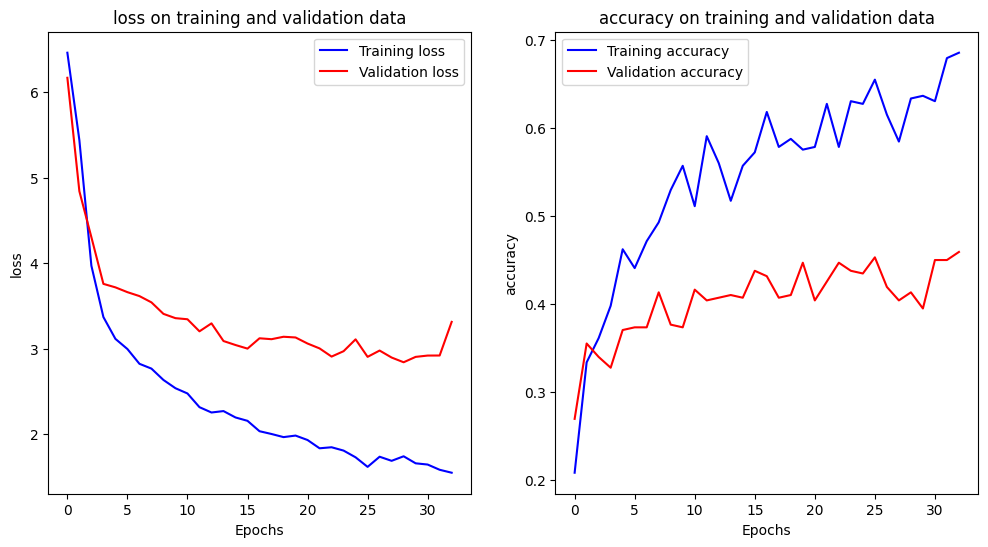

In [ ]:
finetuned.plot_curves()

### Modell tesztelése

11/11 [==============================] - 0s 4ms/step
Test accuracy:  0.40366971492767334


Text(0.5, 1.0, 'Confusion Matrix')

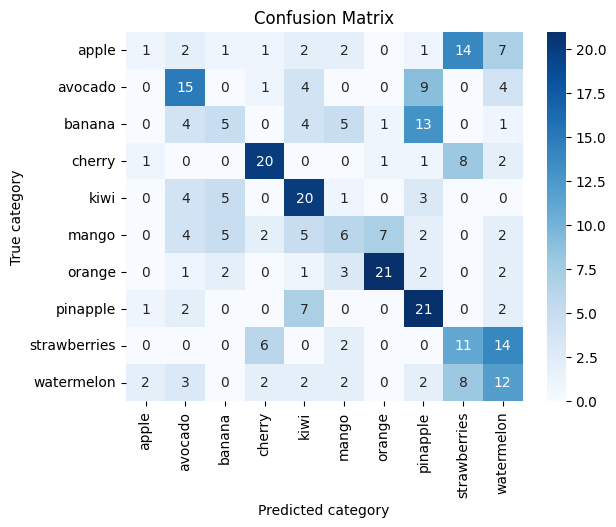

In [ ]:
finetuned_results = finetuned.model.evaluate(xs_test, ys_test)
finetuned_test_ce = finetuned_results[0]
finetuned_test_acc = finetuned_results[1]

finetuned_predicts = finetuned.model.predict(xs_test)
finetuned_predicted_labels = np.argmax(finetuned_predicts, axis=1)

test_labels = np.argmax(ys_test, axis=1)

print("Test accuracy: ", finetuned_test_acc)

finetuned_confusion_matrix = metrics.confusion_matrix(test_labels, finetuned_predicted_labels)
seaborn.heatmap(finetuned_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'],\
                yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'])
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.title('Confusion Matrix')

## Egyszerű klasszifikáló modell

In [ ]:
basic_classifier = SimpleClassifier(xs=xs_finetuned, ys=ys_finetuned, xs_val=xs_val, ys_val=ys_val)

basic_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model initialization completed
Compilation completed


In [ ]:
basic_classifier.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_166 (Conv2D)         (None, 64, 64, 8)         224       
                                                                 
 batch_normalization_145 (B  (None, 64, 64, 8)         32        
 atchNormalization)                                              
                                                                 
 activation_160 (Activation  (None, 64, 64, 8)         0         
 )                                                               
                                                                 
 conv2d_167 (Conv2D)         (None, 64, 64, 8)         584       
                                                                 
 batch_normalization_146 (B  (None, 64, 64, 8)         32 

In [ ]:
basic_classifier.train(epochs=1000, min_delta=0.1, batch_size=32, earlystopping_patience=10)

Early stopping on
Epoch 1/1000
11/11 [==============================] - 8s 134ms/step - loss: 5.4992 - accuracy: 0.0979 - val_loss: 4.2163 - val_accuracy: 0.1009
Epoch 2/1000
11/11 [==============================] - 1s 78ms/step - loss: 4.1704 - accuracy: 0.1529 - val_loss: 4.0985 - val_accuracy: 0.1009
Epoch 3/1000
11/11 [==============================] - 1s 74ms/step - loss: 3.9640 - accuracy: 0.1284 - val_loss: 3.9274 - val_accuracy: 0.1009
Epoch 4/1000
11/11 [==============================] - 1s 77ms/step - loss: 3.7161 - accuracy: 0.1437 - val_loss: 3.7487 - val_accuracy: 0.1009
Epoch 5/1000
11/11 [==============================] - 2s 195ms/step - loss: 3.4285 - accuracy: 0.2049 - val_loss: 3.5888 - val_accuracy: 0.1009
Epoch 6/1000
11/11 [==============================] - 1s 76ms/step - loss: 3.2518 - accuracy: 0.2446 - val_loss: 3.4608 - val_accuracy: 0.1009
Epoch 7/1000
11/11 [==============================] - 1s 79ms/step - loss: 3.0678 - accuracy: 0.2661 - val_loss: 3.3327 - 

### Tanítási görbék

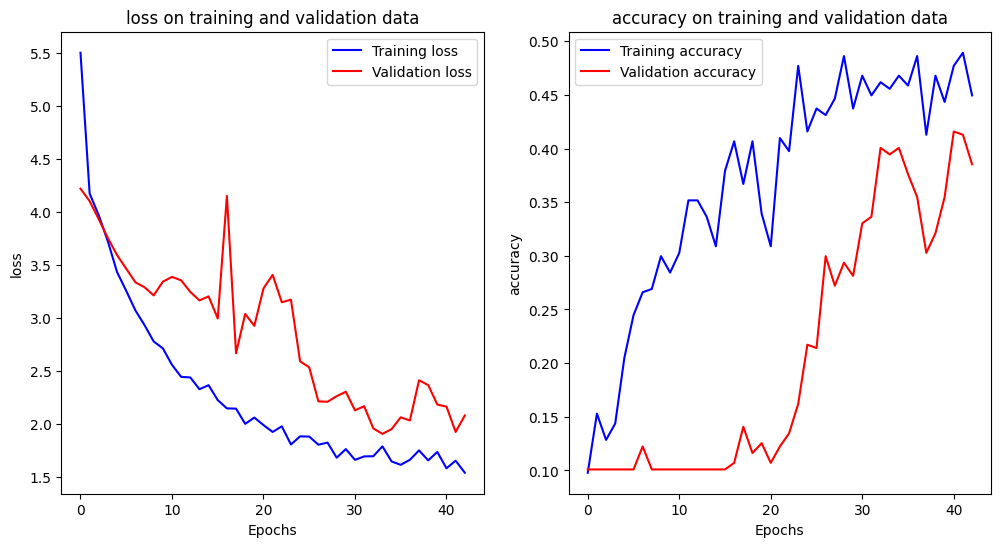

In [ ]:
basic_classifier.plot_curves()

### Modell tesztelése

11/11 [==============================] - 0s 5ms/step
Test accuracy:  0.3333333432674408


Text(0.5, 1.0, 'Confusion Matrix')

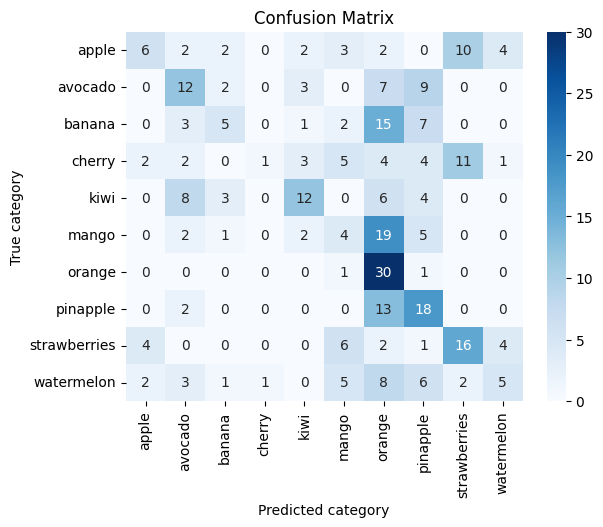

In [ ]:
basic_results = basic_classifier.model.evaluate(xs_test, ys_test)
basic_test_ce = basic_results[0]
basic_test_acc = basic_results[1]

basic_predicts = basic_classifier.model.predict(xs_test)
basic_predicted_labels = np.argmax(basic_predicts, axis=1)

print("Test accuracy: ", basic_test_acc)

basic_confusion_matrix = metrics.confusion_matrix(test_labels, basic_predicted_labels)
seaborn.heatmap(basic_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'],\
                yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'])
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.title('Confusion Matrix')

## A két modell összehasonlítása

<Axes: title={'center': 'Finetuned classifier heatmap'}>

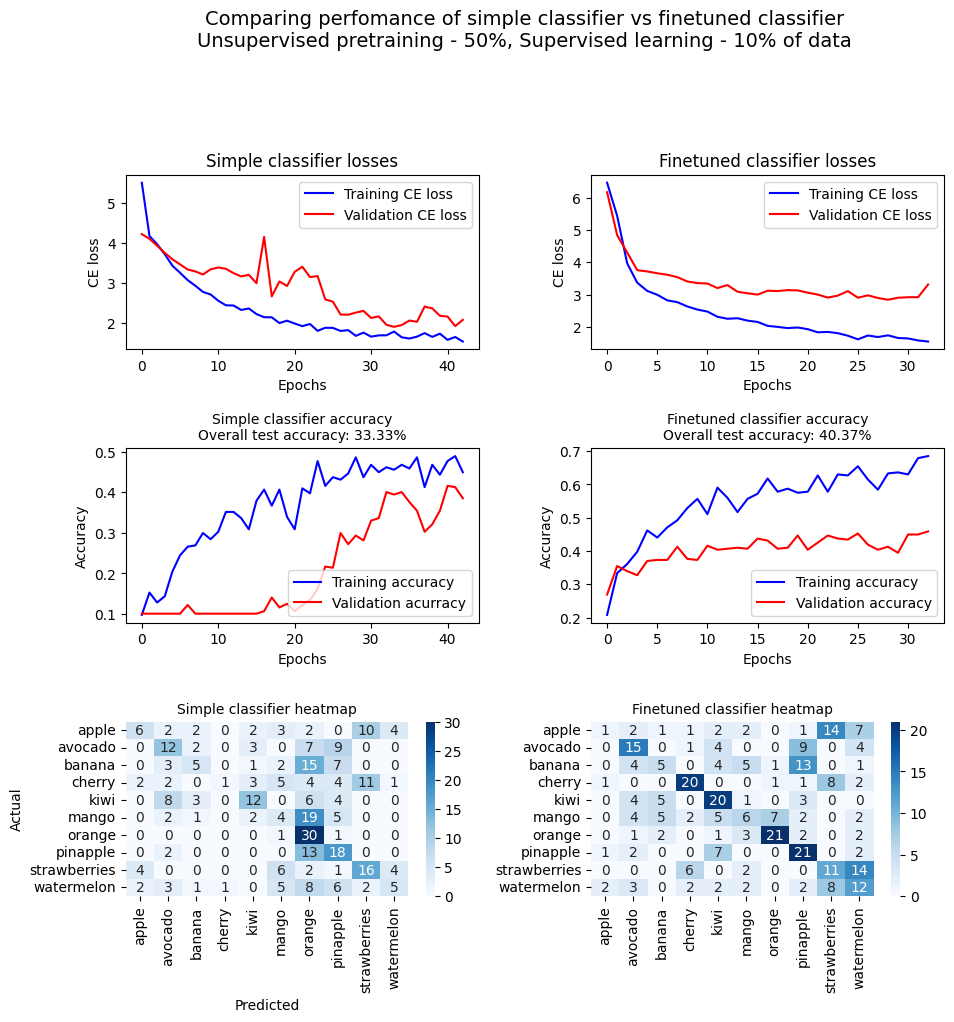

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

fig.suptitle('Comparing perfomance of simple classifier vs finetuned classifier\nUnsupervised pretraining - 50%, Supervised learning - 10% of data', fontsize=14)
fig.tight_layout(pad=5.0)

axs[0,0].plot(basic_classifier.train_loss, 'b', label='Training CE loss')
axs[0,0].plot(basic_classifier.val_loss, 'r', label='Validation CE loss')
axs[0,0].set_title('Simple classifier losses')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('CE loss')
axs[0,0].legend()

axs[0,1].plot(finetuned.train_loss, 'b', label='Training CE loss')
axs[0,1].plot(finetuned.val_loss, 'r', label='Validation CE loss')
axs[0,1].set_title('Finetuned classifier losses')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('CE loss')
axs[0,1].legend()

axs[1,0].plot(basic_classifier.train_acc, 'b', label=f'Training accuracy')
axs[1,0].plot(basic_classifier.val_acc, 'r', label='Validation acurracy')
axs[1,0].set_title(f'\nSimple classifier accuracy\nOverall test accuracy: {round(basic_test_acc * 100, 2)}%', fontsize=10)
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].legend()

axs[1,1].plot(finetuned.train_acc, 'b', label='Training accuracy')
axs[1,1].plot(finetuned.val_acc, 'r', label='Validation accuracy')
axs[1,1].set_title(f'\nFinetuned classifier accuracy\nOverall test accuracy: {round(finetuned_test_acc * 100, 2)}%', fontsize=10)
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].legend()

axs[2,0].set_title('Simple classifier heatmap', fontsize=10)
seaborn.heatmap(basic_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,ax=axs[2,0])
axs[2,0].set_xlabel('Predicted')
axs[2,0].set_ylabel('Actual')

axs[2,1].set_title('Finetuned classifier heatmap', fontsize=10)
seaborn.heatmap(finetuned_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,ax=axs[2,1])


# Második konfiguráció (50%-20%-10%-10%)

* Az autoencoder az adathalmaz 50%-án tanul
* Az előtanított modellt az adatahalmaz 20%-án fine-tuneoljuk, a sima klasszifikáló az adathalmaz ugyan ezen 20%-án tanul
* Mindegyik modellt az adathalmaz 10-10%-án validáljuk és teszteljük



In [ ]:
SPLIT = (50, 20, 10, 10)

(autoencoder_data, finetuned_data, test_data, val_data) = split_dataset(dataset, SPLIT)

autoencoder_data = permutate(*autoencoder_data)
finetuned_data = permutate(*finetuned_data)
test_data = permutate(*test_data)
val_data = permutate(*val_data)

(xs_autoencoder, ys_autoencoder) = autoencoder_data
(xs_finetuned, ys_finetuned) = finetuned_data
(xs_test, ys_test) = test_data
(xs_val, ys_val) = val_data

df = pd.DataFrame(
    columns=["", f"Autoencoder (~{SPLIT[0]}%)", f"Finetuned (~{SPLIT[1]}%)", f"Test (~{SPLIT[2]}%)",
             f"Val (~{SPLIT[3]}%)", "Total"]
    , data = [
        ['x size', len(xs_autoencoder), len(xs_finetuned), len(xs_test), len(xs_val),
            (len(xs_autoencoder) + len(xs_finetuned) + len(xs_test) + len(xs_val))
        ],
        ['y size', len(ys_autoencoder), len(ys_finetuned), len(ys_test), len(ys_val),
            (len(ys_autoencoder) + len(ys_finetuned) + len(ys_test) + len(ys_val))
        ]
    ]
)


print(df)

           Autoencoder (~50%)  Finetuned (~20%)  Test (~10%)  Val (~10%)  \
0  x size                1659               663          327         327   
1  y size                1659               663          327         327   

   Total  
0   2976  
1   2976  


## Finetuned modell



In [ ]:
finetuned = FinetunedClassifier(xs=xs_finetuned, ys=ys_finetuned,\
    xs_val=xs_val, ys_val=ys_val, autoencoder=autoencoder)

finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model initialization completed
Compilation completed


In [ ]:
# freeze the pretrained weights

for layer in finetuned.model.layers:
  if 'dense' not in layer.name:
    layer.trainable=False
  else:
    break

for layer in finetuned.model.layers:
  print(layer.name, layer.trainable)

input_20 False
conv2d_139 False
batch_normalization_119 False
activation_134 False
conv2d_140 False
batch_normalization_120 False
activation_135 False
max_pooling2d_38 False
conv2d_141 False
batch_normalization_121 False
activation_136 False
conv2d_142 False
batch_normalization_122 False
activation_137 False
max_pooling2d_39 False
conv2d_143 False
batch_normalization_123 False
activation_138 False
conv2d_144 False
batch_normalization_124 False
activation_139 False
flatten_26 False
dropout_52 False
dense_52 True
dropout_53 True
dense_53 True


In [ ]:
finetuned.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_139 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_119 (B  (None, 64, 64, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_134 (Activation  (None, 64, 64, 16)        0         
 )                                                               
                                                                 
 conv2d_140 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_120 (B  (None, 64, 64, 16)        64 

In [ ]:
finetuned.train(epochs=100, batch_size=32, earlystopping_patience=10)

Early stopping on
Epoch 1/100
21/21 [==============================] - 3s 80ms/step - loss: 7.9264 - accuracy: 0.2745 - val_loss: 5.6963 - val_accuracy: 0.3242
Epoch 2/100
21/21 [==============================] - 2s 117ms/step - loss: 4.5685 - accuracy: 0.3017 - val_loss: 3.8545 - val_accuracy: 0.2477
Epoch 3/100
21/21 [==============================] - 1s 58ms/step - loss: 3.6178 - accuracy: 0.3575 - val_loss: 3.4347 - val_accuracy: 0.3853
Epoch 4/100
21/21 [==============================] - 1s 61ms/step - loss: 3.3007 - accuracy: 0.4193 - val_loss: 3.3263 - val_accuracy: 0.4006
Epoch 5/100
21/21 [==============================] - 1s 61ms/step - loss: 3.1337 - accuracy: 0.4389 - val_loss: 3.1069 - val_accuracy: 0.3517
Epoch 6/100
21/21 [==============================] - 1s 58ms/step - loss: 2.8852 - accuracy: 0.4570 - val_loss: 2.9240 - val_accuracy: 0.3792
Epoch 7/100
21/21 [==============================] - 1s 59ms/step - loss: 2.7799 - accuracy: 0.4208 - val_loss: 2.8044 - val_accu

### Tanítási görbék

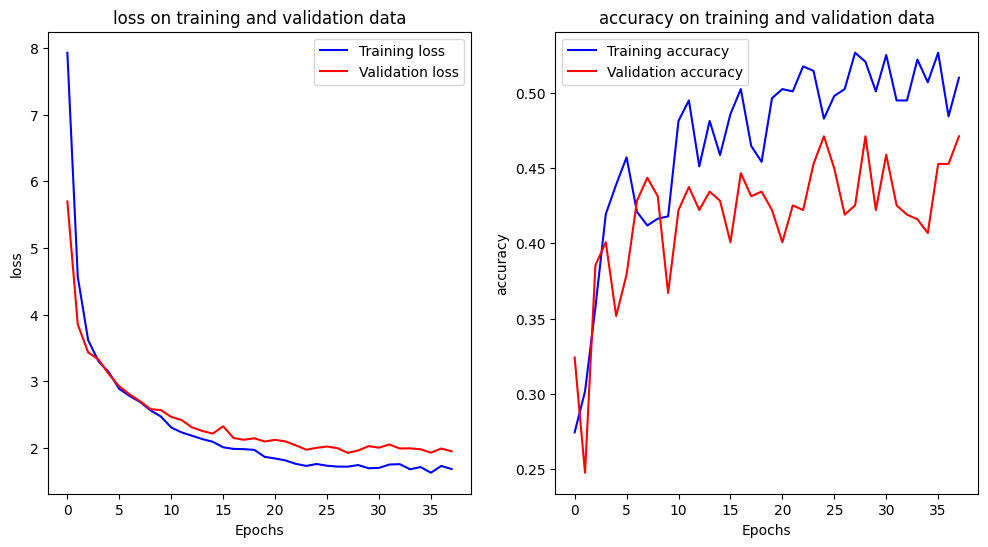

In [ ]:
finetuned.plot_curves()

### Modell tesztelése

11/11 [==============================] - 0s 4ms/step
Test accuracy:  0.43119266629219055


Text(0.5, 1.0, 'Confusion Matrix')

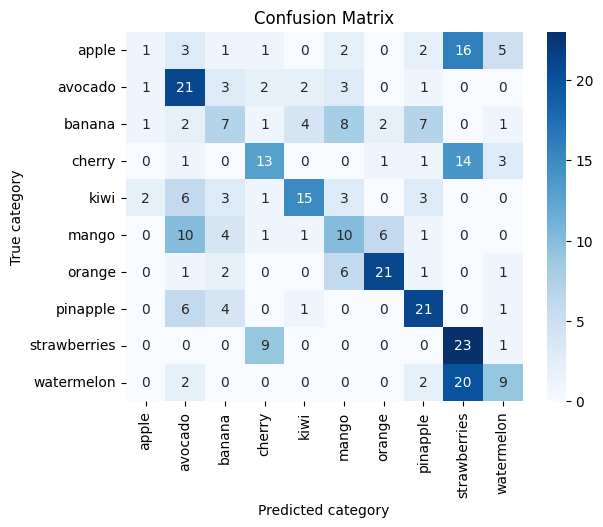

In [ ]:
finetuned_results = finetuned.model.evaluate(xs_test, ys_test)
finetuned_test_ce = finetuned_results[0]
finetuned_test_acc = finetuned_results[1]

finetuned_predicts = finetuned.model.predict(xs_test)
finetuned_predicted_labels = np.argmax(finetuned_predicts, axis=1)

test_labels = np.argmax(ys_test, axis=1)

print("Test accuracy: ", finetuned_test_acc)

finetuned_confusion_matrix = metrics.confusion_matrix(test_labels, finetuned_predicted_labels)
seaborn.heatmap(finetuned_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'],\
                yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'])
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.title('Confusion Matrix')

## Egyszerű klasszifikáló modell



In [ ]:
basic_classifier = SimpleClassifier(xs=xs_finetuned, ys=ys_finetuned, xs_val=xs_val, ys_val=ys_val)

basic_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model initialization completed
Compilation completed


In [ ]:
basic_classifier.summary()

In [ ]:
basic_classifier.train(epochs=100, batch_size=32, earlystopping_patience=10)

Early stopping on
Epoch 1/100
21/21 [==============================] - 7s 118ms/step - loss: 4.8518 - accuracy: 0.1373 - val_loss: 4.1405 - val_accuracy: 0.1009
Epoch 2/100
21/21 [==============================] - 1s 62ms/step - loss: 3.8774 - accuracy: 0.1644 - val_loss: 3.8281 - val_accuracy: 0.1009
Epoch 3/100
21/21 [==============================] - 2s 111ms/step - loss: 3.5070 - accuracy: 0.2021 - val_loss: 3.5623 - val_accuracy: 0.1009
Epoch 4/100
21/21 [==============================] - 1s 68ms/step - loss: 3.2143 - accuracy: 0.1991 - val_loss: 3.3240 - val_accuracy: 0.1009
Epoch 5/100
21/21 [==============================] - 1s 60ms/step - loss: 2.9398 - accuracy: 0.2142 - val_loss: 3.1424 - val_accuracy: 0.1009
Epoch 6/100
21/21 [==============================] - 1s 59ms/step - loss: 2.6983 - accuracy: 0.2504 - val_loss: 3.0374 - val_accuracy: 0.1315
Epoch 7/100
21/21 [==============================] - 1s 61ms/step - loss: 2.5644 - accuracy: 0.2217 - val_loss: 2.9569 - val_acc

### Tanítási görbék

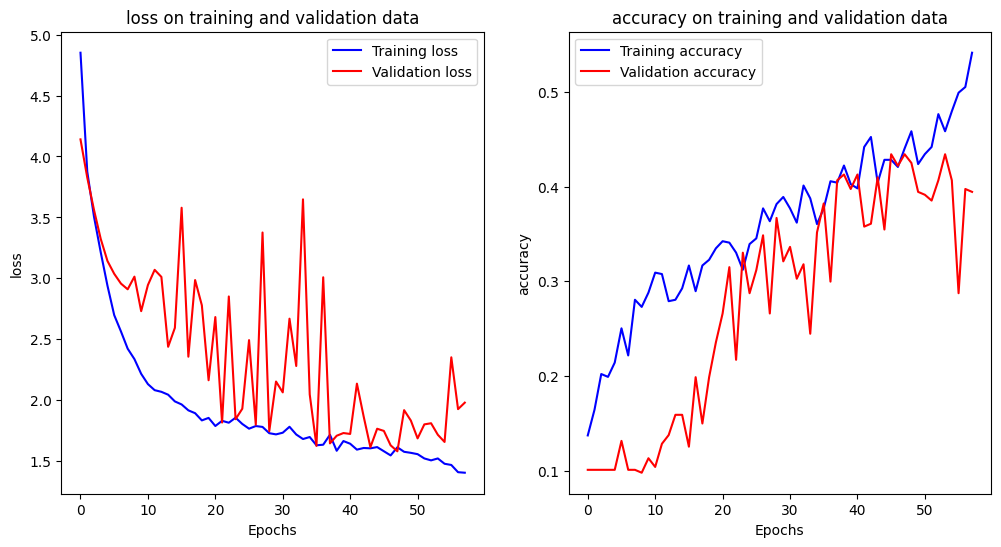

In [ ]:
basic_classifier.plot_curves()

### Modell tesztelése

11/11 [==============================] - 0s 3ms/step
Test accuracy:  0.4678899049758911


Text(0.5, 1.0, 'Confusion Matrix')

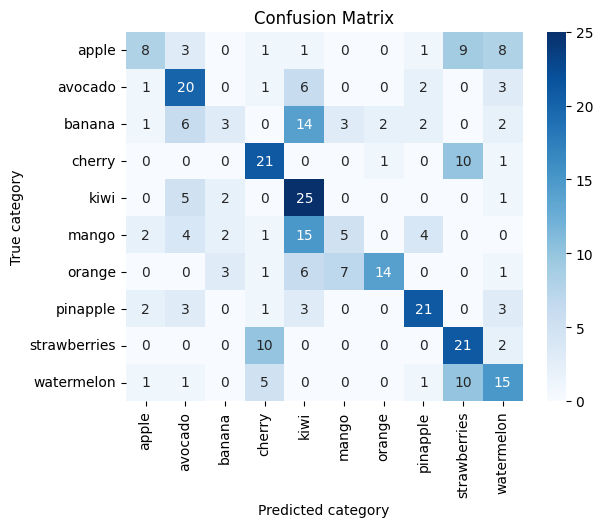

In [ ]:
basic_results = basic_classifier.model.evaluate(xs_test, ys_test)
basic_test_ce = basic_results[0]
basic_test_acc = basic_results[1]

basic_predicts = basic_classifier.model.predict(xs_test)
basic_predicted_labels = np.argmax(basic_predicts, axis=1)

print("Test accuracy: ", basic_test_acc)

basic_confusion_matrix = metrics.confusion_matrix(test_labels, basic_predicted_labels)
seaborn.heatmap(basic_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'],\
                yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'])
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.title('Confusion Matrix')

## A két modell összehasonlítása

<Axes: title={'center': 'Finetuned classifier heatmap'}>

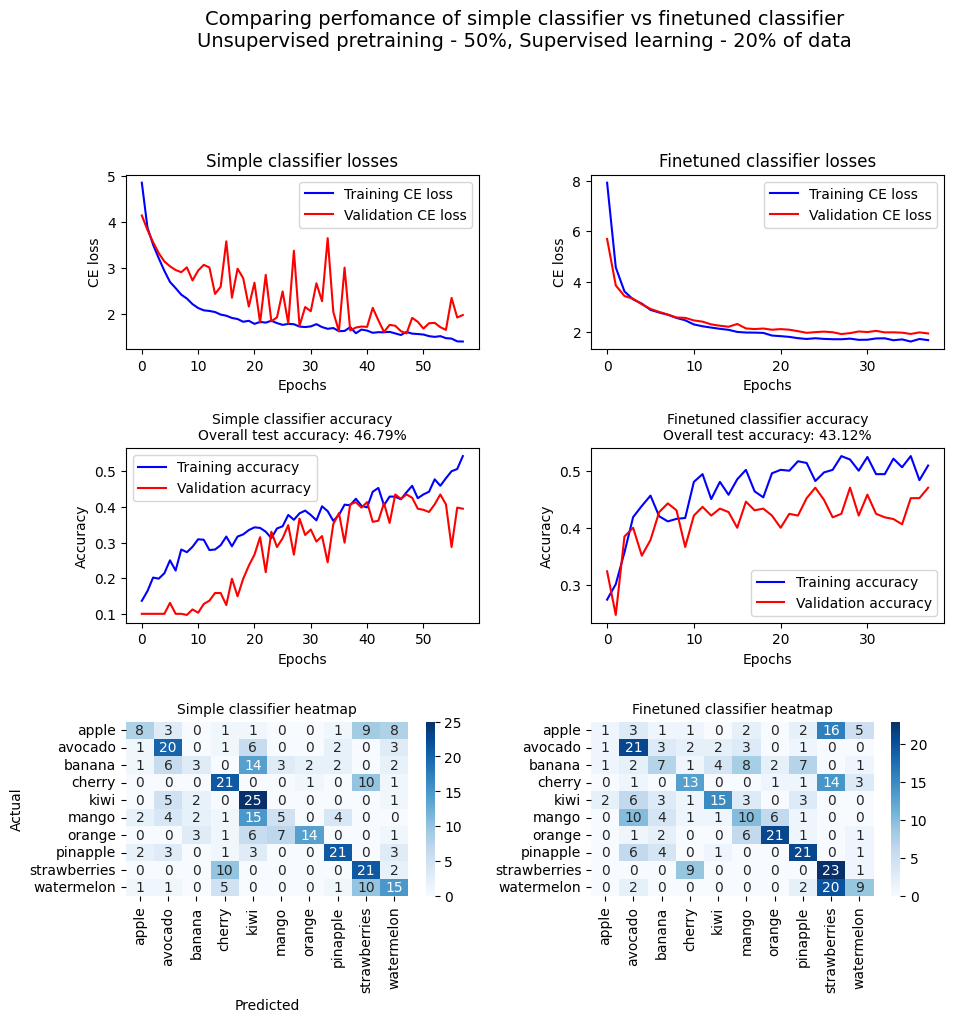

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

fig.suptitle('Comparing perfomance of simple classifier vs finetuned classifier\nUnsupervised pretraining - 50%, Supervised learning - 20% of data', fontsize=14)
fig.tight_layout(pad=5.0)

axs[0,0].plot(basic_classifier.train_loss, 'b', label='Training CE loss')
axs[0,0].plot(basic_classifier.val_loss, 'r', label='Validation CE loss')
axs[0,0].set_title('Simple classifier losses')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('CE loss')
axs[0,0].legend()

axs[0,1].plot(finetuned.train_loss, 'b', label='Training CE loss')
axs[0,1].plot(finetuned.val_loss, 'r', label='Validation CE loss')
axs[0,1].set_title('Finetuned classifier losses')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('CE loss')
axs[0,1].legend()

axs[1,0].plot(basic_classifier.train_acc, 'b', label=f'Training accuracy')
axs[1,0].plot(basic_classifier.val_acc, 'r', label='Validation acurracy')
axs[1,0].set_title(f'\nSimple classifier accuracy\nOverall test accuracy: {round(basic_test_acc * 100, 2)}%', fontsize=10)
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].legend()

axs[1,1].plot(finetuned.train_acc, 'b', label='Training accuracy')
axs[1,1].plot(finetuned.val_acc, 'r', label='Validation accuracy')
axs[1,1].set_title(f'\nFinetuned classifier accuracy\nOverall test accuracy: {round(finetuned_test_acc * 100, 2)}%', fontsize=10)
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].legend()

axs[2,0].set_title('Simple classifier heatmap', fontsize=10)
seaborn.heatmap(basic_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,ax=axs[2,0])
axs[2,0].set_xlabel('Predicted')
axs[2,0].set_ylabel('Actual')

axs[2,1].set_title('Finetuned classifier heatmap', fontsize=10)
seaborn.heatmap(finetuned_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,ax=axs[2,1])


# Harmadik konfiguráció (50%-30%-10%-10%)

* Az autoencoder az adathalmaz 50%-án tanul
* Az előtanított modellt az adatahalmaz 30%-án fine-tuneoljuk, a sima klasszifikáló az adathalmaz ugyan ezen 30%-án tanul
* Mindegyik modellt az adathalmaz 10-10%-án validáljuk és teszteljük

In [ ]:
SPLIT = (50, 30, 10, 10)

(autoencoder_data, finetuned_data, test_data, val_data) = split_dataset(dataset, SPLIT)

autoencoder_data = permutate(*autoencoder_data)
finetuned_data = permutate(*finetuned_data)
test_data = permutate(*test_data)
val_data = permutate(*val_data)

(xs_autoencoder, ys_autoencoder) = autoencoder_data
(xs_finetuned, ys_finetuned) = finetuned_data
(xs_test, ys_test) = test_data
(xs_val, ys_val) = val_data

df = pd.DataFrame(
    columns=["", f"Autoencoder (~{SPLIT[0]}%)", f"Finetuned (~{SPLIT[1]}%)", f"Test (~{SPLIT[2]}%)",
             f"Val (~{SPLIT[3]}%)", "Total"]
    , data = [
        ['x size', len(xs_autoencoder), len(xs_finetuned), len(xs_test), len(xs_val),
            (len(xs_autoencoder) + len(xs_finetuned) + len(xs_test) + len(xs_val))
        ],
        ['y size', len(ys_autoencoder), len(ys_finetuned), len(ys_test), len(ys_val),
            (len(ys_autoencoder) + len(ys_finetuned) + len(ys_test) + len(ys_val))
        ]
    ]
)


print(df)

           Autoencoder (~50%)  Finetuned (~30%)  Test (~10%)  Val (~10%)  \
0  x size                1659               992          327         327   
1  y size                1659               992          327         327   

   Total  
0   3305  
1   3305  


## Finetuned modell

In [ ]:
finetuned = FinetunedClassifier(xs=xs_finetuned, ys=ys_finetuned,\
    xs_val=xs_val, ys_val=ys_val, autoencoder=autoencoder)

finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model initialization completed
Compilation completed


In [ ]:
# freeze the pretrained weights

for layer in finetuned.model.layers:
  if 'dense' not in layer.name:
    layer.trainable=False
  else:
    break

for layer in finetuned.model.layers:
  print(layer.name, layer.trainable)

input_20 False
conv2d_139 False
batch_normalization_119 False
activation_134 False
conv2d_140 False
batch_normalization_120 False
activation_135 False
max_pooling2d_38 False
conv2d_141 False
batch_normalization_121 False
activation_136 False
conv2d_142 False
batch_normalization_122 False
activation_137 False
max_pooling2d_39 False
conv2d_143 False
batch_normalization_123 False
activation_138 False
conv2d_144 False
batch_normalization_124 False
activation_139 False
flatten_28 False
dropout_56 False
dense_56 True
dropout_57 True
dense_57 True


In [ ]:
finetuned.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_139 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_119 (B  (None, 64, 64, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_134 (Activation  (None, 64, 64, 16)        0         
 )                                                               
                                                                 
 conv2d_140 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_120 (B  (None, 64, 64, 16)        64 

In [ ]:
finetuned.train(epochs=100, batch_size=32, earlystopping_patience=10)

Early stopping on
Epoch 1/300
31/31 [==============================] - 3s 60ms/step - loss: 6.4062 - accuracy: 0.2681 - val_loss: 4.3455 - val_accuracy: 0.3547
Epoch 2/300
31/31 [==============================] - 2s 52ms/step - loss: 3.7721 - accuracy: 0.2893 - val_loss: 3.4700 - val_accuracy: 0.3394
Epoch 3/300
31/31 [==============================] - 2s 52ms/step - loss: 3.2739 - accuracy: 0.3185 - val_loss: 3.0097 - val_accuracy: 0.4128
Epoch 4/300
31/31 [==============================] - 2s 79ms/step - loss: 2.9116 - accuracy: 0.4062 - val_loss: 2.7493 - val_accuracy: 0.4312
Epoch 5/300
31/31 [==============================] - 2s 49ms/step - loss: 2.6777 - accuracy: 0.4264 - val_loss: 2.6080 - val_accuracy: 0.4434
Epoch 6/300
31/31 [==============================] - 2s 50ms/step - loss: 2.5118 - accuracy: 0.4234 - val_loss: 2.3867 - val_accuracy: 0.4526
Epoch 7/300
31/31 [==============================] - 2s 52ms/step - loss: 2.3772 - accuracy: 0.4425 - val_loss: 2.3610 - val_accur

### Tanítási görbék

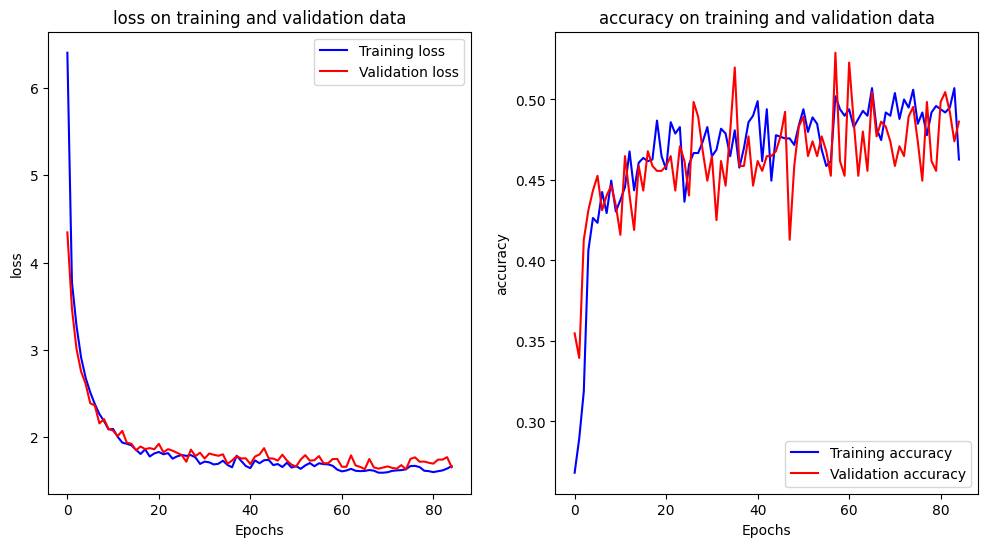

In [ ]:
finetuned.plot_curves()

### Modell tesztelése

11/11 [==============================] - 0s 4ms/step
Test accuracy:  0.47400611639022827


Text(0.5, 1.0, 'Confusion Matrix')

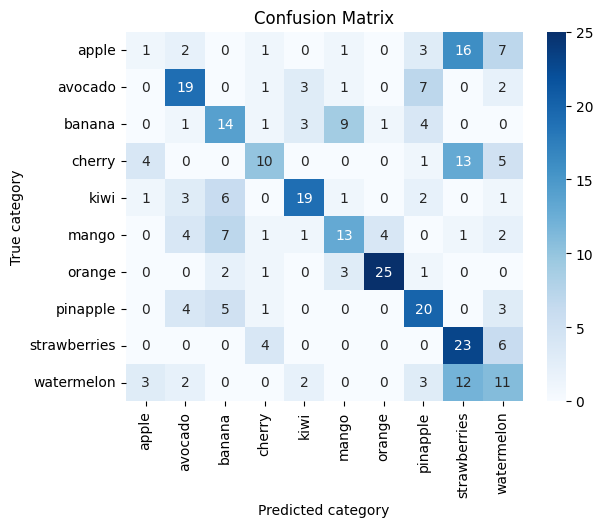

In [ ]:
finetuned_results = finetuned.model.evaluate(xs_test, ys_test)
finetuned_test_ce = finetuned_results[0]
finetuned_test_acc = finetuned_results[1]

finetuned_predicts = finetuned.model.predict(xs_test)
finetuned_predicted_labels = np.argmax(finetuned_predicts, axis=1)

test_labels = np.argmax(ys_test, axis=1)

print("Test accuracy: ", finetuned_test_acc)

finetuned_confusion_matrix = metrics.confusion_matrix(test_labels, finetuned_predicted_labels)
seaborn.heatmap(finetuned_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'],\
                yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'])
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.title('Confusion Matrix')

## Egyszerű klasszifikáló modell

In [ ]:
basic_classifier = SimpleClassifier(xs=xs_finetuned, ys=ys_finetuned, xs_val=xs_val, ys_val=ys_val)

basic_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model initialization completed
Compilation completed


In [ ]:
basic_classifier.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_190 (Conv2D)         (None, 64, 64, 8)         224       
                                                                 
 batch_normalization_169 (B  (None, 64, 64, 8)         32        
 atchNormalization)                                              
                                                                 
 activation_184 (Activation  (None, 64, 64, 8)         0         
 )                                                               
                                                                 
 conv2d_191 (Conv2D)         (None, 64, 64, 8)         584       
                                                                 
 batch_normalization_170 (B  (None, 64, 64, 8)         32 

In [ ]:
basic_classifier.train(epochs=100, batch_size=32, earlystopping_patience=10)

Early stopping on
Epoch 1/100
31/31 [==============================] - 7s 61ms/step - loss: 4.6477 - accuracy: 0.1331 - val_loss: 3.9959 - val_accuracy: 0.1009
Epoch 2/100
31/31 [==============================] - 2s 56ms/step - loss: 3.6076 - accuracy: 0.1956 - val_loss: 3.5291 - val_accuracy: 0.0917
Epoch 3/100
31/31 [==============================] - 2s 53ms/step - loss: 3.1070 - accuracy: 0.2319 - val_loss: 3.2176 - val_accuracy: 0.1009
Epoch 4/100
31/31 [==============================] - 2s 55ms/step - loss: 2.7707 - accuracy: 0.2329 - val_loss: 3.0677 - val_accuracy: 0.1009
Epoch 5/100
31/31 [==============================] - 2s 53ms/step - loss: 2.5902 - accuracy: 0.2520 - val_loss: 2.8633 - val_accuracy: 0.1284
Epoch 6/100
31/31 [==============================] - 3s 81ms/step - loss: 2.3757 - accuracy: 0.2661 - val_loss: 2.9401 - val_accuracy: 0.1346
Epoch 7/100
31/31 [==============================] - 2s 56ms/step - loss: 2.2588 - accuracy: 0.2782 - val_loss: 2.7545 - val_accur

### Tanítási görbék

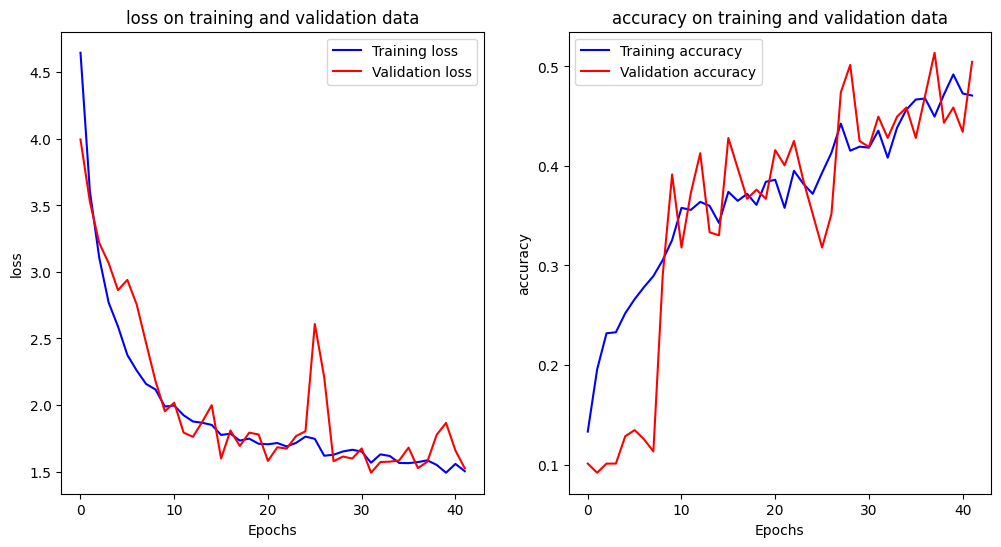

In [ ]:
basic_classifier.plot_curves()

### Modell tesztelése

11/11 [==============================] - 0s 4ms/step
Test accuracy:  0.4954128563404083


Text(0.5, 1.0, 'Confusion Matrix')

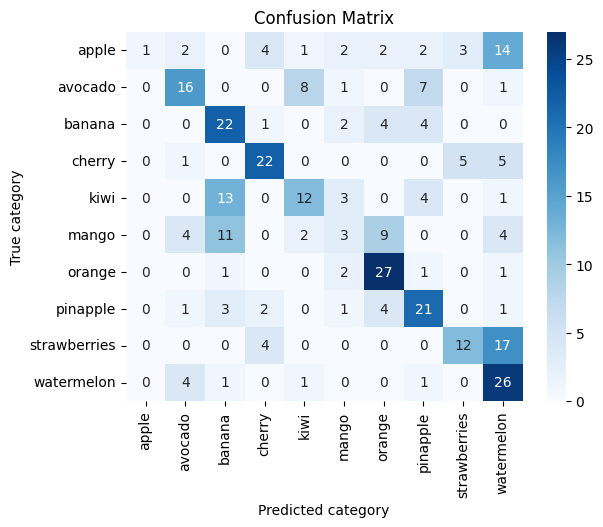

In [ ]:
basic_results = basic_classifier.model.evaluate(xs_test, ys_test)
basic_test_ce = basic_results[0]
basic_test_acc = basic_results[1]

basic_predicts = basic_classifier.model.predict(xs_test)
basic_predicted_labels = np.argmax(basic_predicts, axis=1)

print("Test accuracy: ", basic_test_acc)

basic_confusion_matrix = metrics.confusion_matrix(test_labels, basic_predicted_labels)
seaborn.heatmap(basic_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'],\
                yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon'])
plt.xlabel('Predicted category')
plt.ylabel('True category')
plt.title('Confusion Matrix')

## A két modell összehasonlítása

<Axes: title={'center': 'Finetuned classifier heatmap'}>

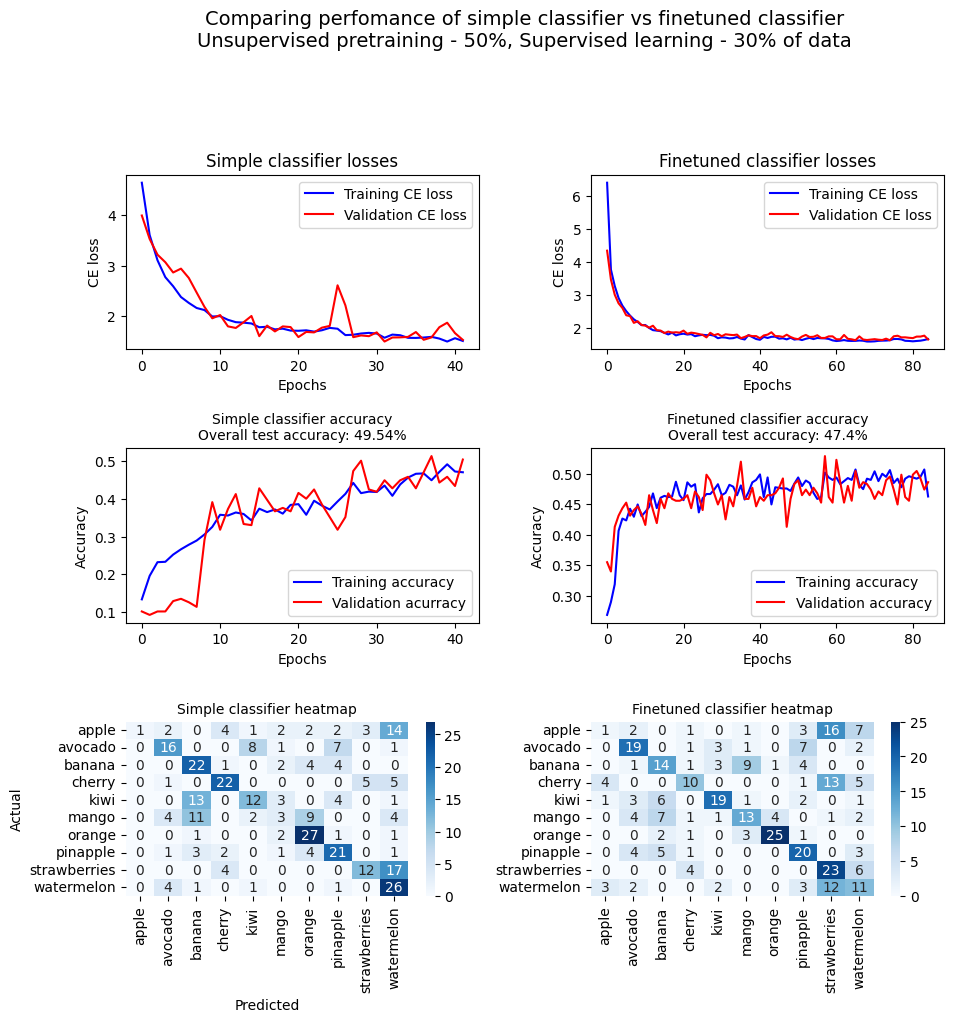

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

fig.suptitle('Comparing perfomance of simple classifier vs finetuned classifier\nUnsupervised pretraining - 50%, Supervised learning - 30% of data', fontsize=14)
fig.tight_layout(pad=5.0)

axs[0,0].plot(basic_classifier.train_loss, 'b', label='Training CE loss')
axs[0,0].plot(basic_classifier.val_loss, 'r', label='Validation CE loss')
axs[0,0].set_title('Simple classifier losses')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('CE loss')
axs[0,0].legend()

axs[0,1].plot(finetuned.train_loss, 'b', label='Training CE loss')
axs[0,1].plot(finetuned.val_loss, 'r', label='Validation CE loss')
axs[0,1].set_title('Finetuned classifier losses')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('CE loss')
axs[0,1].legend()

axs[1,0].plot(basic_classifier.train_acc, 'b', label=f'Training accuracy')
axs[1,0].plot(basic_classifier.val_acc, 'r', label='Validation acurracy')
axs[1,0].set_title(f'\nSimple classifier accuracy\nOverall test accuracy: {round(basic_test_acc * 100, 2)}%', fontsize=10)
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].legend()

axs[1,1].plot(finetuned.train_acc, 'b', label='Training accuracy')
axs[1,1].plot(finetuned.val_acc, 'r', label='Validation accuracy')
axs[1,1].set_title(f'\nFinetuned classifier accuracy\nOverall test accuracy: {round(finetuned_test_acc * 100, 2)}%', fontsize=10)
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].legend()

axs[2,0].set_title('Simple classifier heatmap', fontsize=10)
seaborn.heatmap(basic_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,ax=axs[2,0])
axs[2,0].set_xlabel('Predicted')
axs[2,0].set_ylabel('Actual')

axs[2,1].set_title('Finetuned classifier heatmap', fontsize=10)
seaborn.heatmap(finetuned_confusion_matrix, annot=True, cmap='Blues',\
                xticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,yticklabels=['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinapple', 'strawberries', 'watermelon']
                ,ax=axs[2,1])


# Megfigyelések

- Látható, hogy összességében véve sokat nem segített az előtanítás, sőt, a második és harmadik konfigurációnál már – habár csak kicsivel, de – rosszabb predikciókat adott el az előtanított háló.
- Ennek ellenére az is feltűnik, hogy mindegyik esetben, habár a training accuracy viszonylag gyorsan növekszik, előtanítatlan esetben a validation accuracy csak lassan kezd el emelkedni, előtanított esetben viszont már az első néhány epoch után 30% fölött mozog a validation accuracy. Ez azt jelentheti, hogy az előtanított súlyok hasznára voltak a hálónak az indulásnál, a random inicializált súlyokkal ellentétben.
- Továbbá, ahogy növekszik a címkézett adatok száma, kis mértékben, de növekszik a hálók teljesítménye.


# További lehetséges kísérletek lehetnének:

*	Autoencoder betanítása jóval nagyobb adatbázison
*	Autoencoder súlyok fagyasztása nélküli fine-tuning
  *	minden súly tanítható
  *	csak első néhány réteg-beli súlyok befagyasztása, későbbi rétegek súlyai taníthatóak
*	Másféle architektúrák használata az autoencoderben és a CNN klasszifikációs hálóban
*	Teljesítmények összevetése augmentálással és anélkül
